In [1]:
import matplotlib as mpl
mpl.rc('font',**{'family':'serif','serif':['Times']})
mpl.rc('text', usetex=True)
#mpl.rcParams['text.latex.preview'] = True
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mplhep as hep
import numpy as np
import sklearn.metrics as skl
import os
import mplhep as hep
import pathlib
from collections import namedtuple

import laspaclu.src.analysis.roc as roc
import laspaclu.src.util.logging as log
import laspaclu.src.util.string_constants as stco
import pofah.jet_sample as jesa
import anpofah.model_analysis.roc_analysis as ra

In [2]:
#****************************************#
#           Runtime Params
#****************************************#


Parameters = namedtuple('Parameters', 'sample_id_qcd sample_id_sigs read_n')
params = Parameters(sample_id_qcd='qcdSigExt',
                    sample_id_sigs=['GtoWW35na', 'GtoWW15br', 'AtoHZ35'], 
                    read_n=int(5e4))

#**********************************************************#
#    PLOT ALL SIGNALS, FIXED DIM=8, FIXED-N=600 (run 45)
#**********************************************************#

#****************************************#
#               READ DATA

run_n = 44
dim_z = 4
train_n = 600

In [3]:
input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

sample_qcd = jesa.JetSample.from_input_file(name=params.sample_id_qcd, path=input_data_dir+'/'+params.sample_id_qcd+'.h5').filter(slice(params.read_n))

scores_qcd_c = sample_qcd['classic_loss']
scores_qcd_q = sample_qcd['quantum_loss']

ll_scores_qcd_c = []; ll_scores_qcd_q = []
ll_scores_sig_c = []; ll_scores_sig_q = []
for sample_id_sig in params.sample_id_sigs:
    ll_scores_qcd_c.append(scores_qcd_c)
    ll_scores_qcd_q.append(scores_qcd_q)
    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))
    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])

In [4]:
def prepare_truths_and_scores(scores_bg, scores_sig):
    
    y_truths = np.concatenate([np.zeros(len(scores_bg)), np.ones(len(scores_sig))])
    y_scores = np.concatenate([scores_bg, scores_sig])
    
    return y_truths, y_scores

In [5]:
def plot_roc(ll_sc_bg_c, ll_sc_sig_c, ll_sc_bg_q, ll_sc_sig_q, main_legend_labels, main_legend_title, base_n=int(1e3), auc_legend_offset=0.07):
    
    plt.style.use(hep.style.CMS)
    line_styles = ['solid', 'dashed']
    fig = plt.figure(figsize=(8, 8))
    
    aucs = []
    for sc_bg_c, sc_bg_q, sc_sig_c, sc_sig_q, cc in zip(ll_sc_bg_c, ll_sc_bg_q, ll_sc_sig_c, ll_sc_sig_q, stco.multi_sig_palette):
        
        y_truths_q, y_scores_q = prepare_truths_and_scores(sc_bg_q, sc_sig_q)
        y_truths_c, y_scores_c = prepare_truths_and_scores(sc_bg_c, sc_sig_c)
        
        fpr_q, tpr_q, _ = skl.roc_curve(y_truths_q, y_scores_q)
        fpr_c, tpr_c, _ = skl.roc_curve(y_truths_c, y_scores_c)
            
        aucs.append(skl.roc_auc_score(y_truths_q, y_scores_q))
        aucs.append(skl.roc_auc_score(y_truths_c, y_scores_c))
        
        plt.loglog(tpr_q, 1./fpr_q, linestyle='solid', color=cc)
        plt.loglog(tpr_c, 1./fpr_c, linestyle='dashed', color=cc)
        
    # plot random decision line
    plt.loglog(np.linspace(0, 1, num=base_n), 1./np.linspace(0, 1, num=base_n), linewidth=1.2, linestyle='solid', color='silver')

    dummy_res_lines = [Line2D([0,1],[0,1],linestyle=s, color='gray') for s in line_styles[:2]]

    # add 2 legends (classic vs quantum and resonance types)
    lines = plt.gca().get_lines()
    
    legend1 = plt.legend(dummy_res_lines, [r'Quantum', r'Classic'], loc='lower left', frameon=False, title='algorithm', \
            handlelength=1.5, fontsize=14, title_fontsize=17, bbox_to_anchor=(0,0.28))
    
    main_legend_labels = [r"{}".format(lbl) for lbl in main_legend_labels]
    legend2 = plt.legend([lines[i*len(line_styles)] for i in range(len(main_legend_labels))], main_legend_labels, loc='lower left', \
            frameon=False, title=main_legend_title, fontsize=14, title_fontsize=17)
    
    auc_legend_labels = [r"$  {:.3f} \,\,|\,\, {:.3f}$".format(aucs[i*2],aucs[i*2+1]) for i in range(len(main_legend_labels))]
    auc_legend_title = r"auc$\,\,q\,\,\vert\,\,c$"
    legend3 = plt.legend([lines[i*len(line_styles)] for i in range(len(main_legend_labels))], auc_legend_labels, loc='lower center', \
            frameon=False, title=auc_legend_title, fontsize=14, title_fontsize=17) 
    
    legend1._legend_box.align = "left"
    legend2._legend_box.align = "left"
    legend3._legend_box.align = "center"
    for leg in legend1.legendHandles:
        leg.set_linewidth(2.5)
        leg.set_color('gray')
    for leg in legend2.legendHandles:
        leg.set_linewidth(2.5)
    for leg in legend3.legendHandles:
        leg.set_visible(False)
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)
    plt.gca().add_artist(legend3)
    
    plt.draw()
    
    # Get the bounding box of the original legend
    bb = legend3.get_bbox_to_anchor().inverse_transformed(plt.gca().transAxes)
    # Change to location of the legend. 
    bb.x0 += auc_legend_offset
    bb.x1 += auc_legend_offset
    legend3.set_bbox_to_anchor(bb, transform = plt.gca().transAxes)
    
    # set tick font
#     plt.xticks(fontname = "Times New Roman")  # This argument will change the font.
#     plt.yticks(fontname = "Times New Roman")  # This argument will change the font.

    
#     sizeOfFont = 12
#     fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
#         'weight' : 'normal', 'size' : sizeOfFont}
#     ax = plt.gca()
#     ax.set_xticklabels(ax.get_xticks(), fontProperties)
#     ax.set_yticklabels(ax.get_yticks(), fontProperties)
    
    plt.grid()
    plt.xlabel('True positive rate',fontsize=17)
    plt.ylabel('1 / False positive rate',fontsize=17)
    plt.tight_layout()
        
    plt.show()

# for all signals, fixed z-dim (8) & train-sz (600)

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide

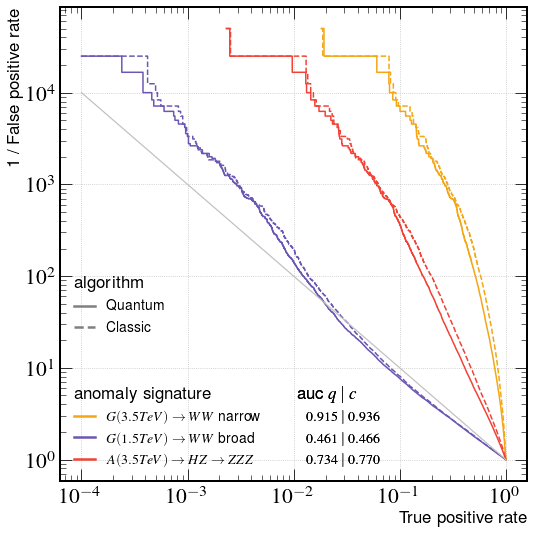

In [6]:
legend_labels = [stco.sample_name_dict[id_sig] for id_sig in params.sample_id_sigs]
legend_title = r'anomaly signature'
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(1e4))

# for all train sizes, fixed latent-dim & signal

## A to HZ to ZZZ

In [7]:
run_n_dict = {
    10: 40,
    600: 44,
    6000: 48,
}

dim_z = 4

#****************************************#
#               A to HZ


sample_id_sig = 'AtoHZ35'

ll_scores_qcd_c = []; ll_scores_qcd_q = []
ll_scores_sig_c = []; ll_scores_sig_q = []

for train_n, run_n in run_n_dict.items():

    input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

    sample_qcd = jesa.JetSample.from_input_file(name=params.sample_id_qcd, path=input_data_dir+'/'+params.sample_id_qcd+'.h5').filter(slice(params.read_n))

    ll_scores_qcd_c.append(sample_qcd['classic_loss'])
    ll_scores_qcd_q.append(sample_qcd['quantum_loss'])

    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide

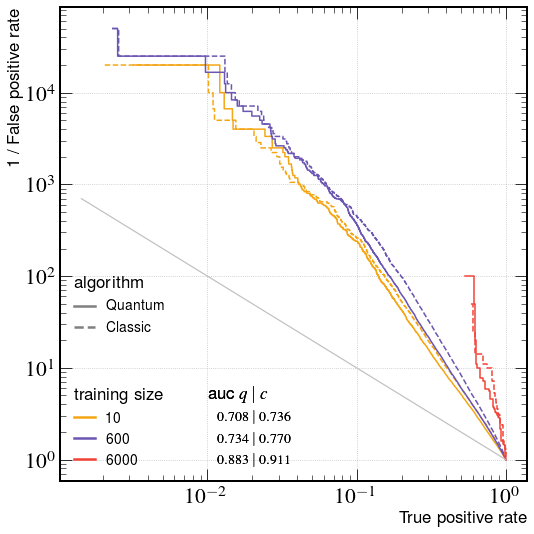

In [8]:
legend_labels=list(run_n_dict.keys())
legend_title = r"training size"
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(7e2), auc_legend_offset=-0.12)

## Grs 1.5TeV broad

In [9]:
#****************************************#
#               G_RS 1.5TeV broad


sample_id_sig = 'GtoWW15br'

ll_scores_sig_c = []; ll_scores_sig_q = []

for train_n, run_n in run_n_dict.items():

    input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide

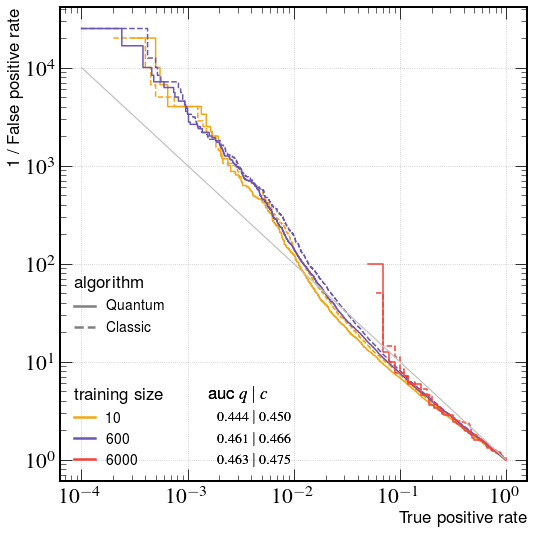

In [10]:
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(1e4), auc_legend_offset=-0.12)

## Grs 3.5TeV narrow

In [11]:
#****************************************#
#               G_RS 3.5TeV na


sample_id_sig = 'GtoWW35na'

ll_scores_sig_c = []; ll_scores_sig_q = []

for train_n, run_n in run_n_dict.items():

    input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide

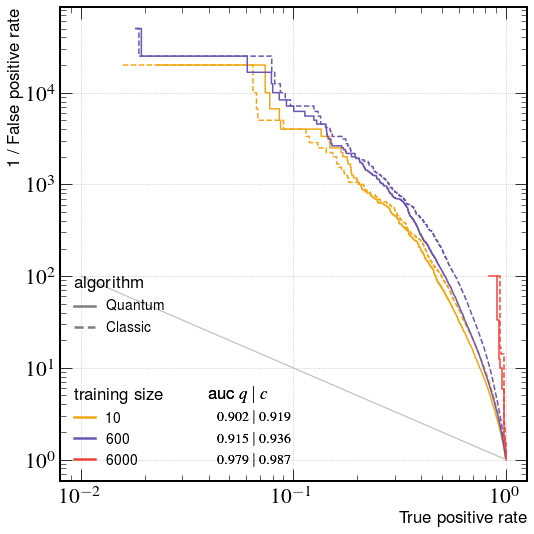

In [12]:
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(1e2), auc_legend_offset=-0.12)

# for all latent dims, fixed train-size & signal

In [24]:
run_n_dict = {
    4: 40,
    8: 41,
    16: 42,
    32: 43
}

train_n = 10

## A to HZ to ZZZ

In [25]:
#****************************************#
#               A to HZ


sample_id_sig = 'AtoHZ35'

ll_scores_qcd_c = []; ll_scores_qcd_q = []
ll_scores_sig_c = []; ll_scores_sig_q = []

for train_n, run_n in run_n_dict.items():

    input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

    sample_qcd = jesa.JetSample.from_input_file(name=params.sample_id_qcd, path=input_data_dir+'/'+params.sample_id_qcd+'.h5').filter(slice(params.read_n))

    ll_scores_qcd_c.append(sample_qcd['classic_loss'])
    ll_scores_qcd_q.append(sample_qcd['quantum_loss'])

    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide

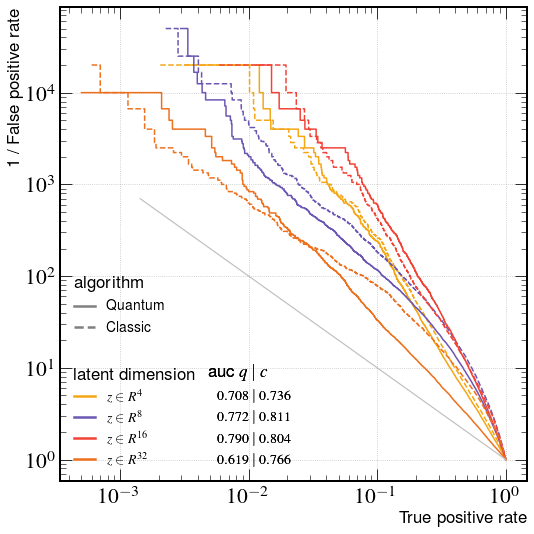

In [26]:
#mpl.rcParams['axes.unicode_minus'] = False
legend_labels=[r"$z \in R^4$",r"$z \in R^8$", r"$z \in R^{16}$", r"$z \in R^{32}$"]
legend_title = r"latent dimension"
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(7e2), auc_legend_offset=-0.12)

## Grs 1.5TeV broad

In [27]:
#****************************************#
#               G_RS 1.5TeV broad


sample_id_sig = 'GtoWW15br'

ll_scores_sig_c = []; ll_scores_sig_q = []

for train_n, run_n in run_n_dict.items():

    input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide

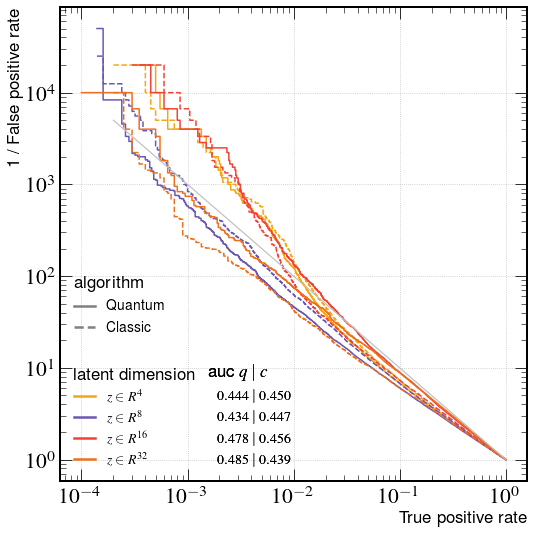

In [28]:
legend_labels=[r"$z \in R^4$",r"$z \in R^8$", r"$z \in R^{16}$", r"$z \in R^{32}$"]
legend_title = r"latent dimension"
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(5e3), auc_legend_offset=-0.12)

## Grs 3.5TeV narrow

In [29]:
#****************************************#
#               G_RS 3.5TeV na


sample_id_sig = 'GtoWW35na'

ll_scores_sig_c = []; ll_scores_sig_q = []

for train_n, run_n in run_n_dict.items():

    input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))

    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])


/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide

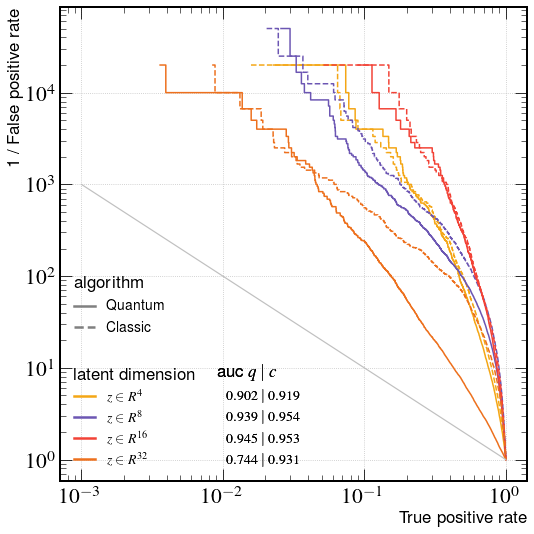

In [30]:
legend_labels=[r"$z \in R^4$",r"$z \in R^8$", r"$z \in R^{16}$", r"$z \in R^{32}$"]
legend_title = r"latent dimension"
plot_roc(ll_scores_qcd_c, ll_scores_sig_c, ll_scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title, base_n=int(1e3), auc_legend_offset=-0.1)

In [95]:
from matplotlib import rcParams
rcParams['text.usetex'] = True

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


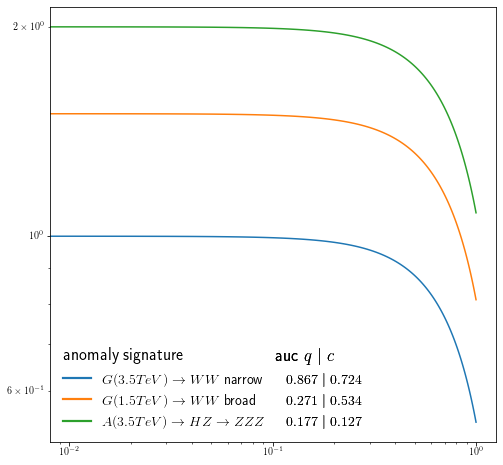

In [24]:
fig = plt.figure(figsize=(8,8))
xx = np.linspace(0,1,100)
plt.loglog(xx,np.cos(xx))
plt.loglog(xx,np.cos(xx)*1.5)
plt.loglog(xx,np.cos(xx)*2)
lines = plt.gca().get_lines()
#main_legend_labels = [r"{}".format(lbl) for lbl in [r"$x^2$",r"$x^{2.5}$",r"$x^{1.5}$"]]
main_legend_labels = [stco.sample_name_dict[id_sig] for id_sig in params.sample_id_sigs]
legend2 = plt.legend([lines[i] for i in range(len(main_legend_labels))], main_legend_labels, loc='lower left', \
        frameon=False, title='anomaly signature', fontsize=14, title_fontsize=17)

auc_legend_labels = [r"$  {:.3f} \,\,|\,\, {:.3f}$".format(np.random.random(),np.random.random()) for i in range(len(main_legend_labels))]
auc_legend_title = r"auc$\,\,q\,\,\vert\,\,c$"
legend3 = plt.legend([lines[i] for i in range(len(main_legend_labels))], auc_legend_labels, loc='lower center', \
         frameon=False, title=auc_legend_title, fontsize=14, title_fontsize=17) 

legend2._legend_box.align = "left"
legend3._legend_box.align = "center"
for leg in legend2.legendHandles:
    leg.set_linewidth(2.2)
for leg in legend3.legendHandles:
     leg.set_visible(False)
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend3)

plt.draw()

auc_legend_offset = 0.07
#Get the bounding box of the original legend
bb = legend3.get_bbox_to_anchor().inverse_transformed(plt.gca().transAxes)
#Change to location of the legend. 
bb.x0 += auc_legend_offset
bb.x1 += auc_legend_offset
legend3.set_bbox_to_anchor(bb, transform = plt.gca().transAxes)

plt.show()

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide

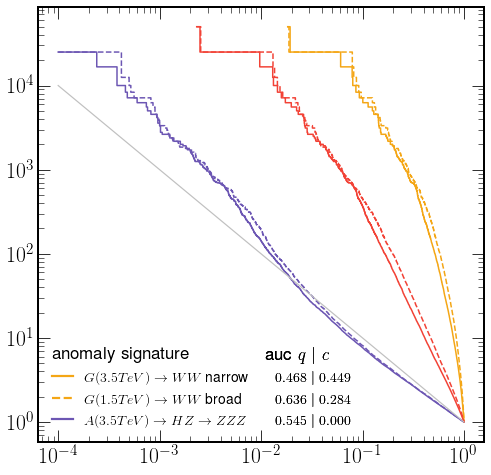

In [31]:
ll_sc_bg_c = ll_scores_qcd_c 
ll_sc_sig_c = ll_scores_sig_c 
ll_sc_bg_q = ll_scores_qcd_q
ll_sc_sig_q = ll_scores_sig_q 
base_n=int(1e4)

plt.style.use(hep.style.CMS)
line_styles = ['solid', 'dashed']
fig = plt.figure(figsize=(8, 8))

aucs = []
for sc_bg_c, sc_bg_q, sc_sig_c, sc_sig_q, cc in zip(ll_sc_bg_c, ll_sc_bg_q, ll_sc_sig_c, ll_sc_sig_q, stco.multi_sig_palette):

    y_truths_q, y_scores_q = prepare_truths_and_scores(sc_bg_q, sc_sig_q)
    y_truths_c, y_scores_c = prepare_truths_and_scores(sc_bg_c, sc_sig_c)

    fpr_q, tpr_q, _ = skl.roc_curve(y_truths_q, y_scores_q)
    fpr_c, tpr_c, _ = skl.roc_curve(y_truths_c, y_scores_c)

    aucs.append(skl.roc_auc_score(y_truths_q, y_scores_q))
    aucs.append(skl.roc_auc_score(y_truths_c, y_scores_c))

    plt.loglog(tpr_q, 1./fpr_q, linestyle='solid', color=cc)
    plt.loglog(tpr_c, 1./fpr_c, linestyle='dashed', color=cc)

lines = plt.gca().get_lines()

# plot random decision line
plt.loglog(np.linspace(0, 1, num=base_n), 1./np.linspace(0, 1, num=base_n), linewidth=1.2, linestyle='solid', color='silver')

dummy_res_lines = [Line2D([0,1],[0,1],linestyle=s, color='gray') for s in line_styles[:2]]

#main_legend_labels = [r"{}".format(lbl) for lbl in [r"$x^2$",r"$x^{2.5}$",r"$x^{1.5}$"]]
main_legend_labels = [stco.sample_name_dict[id_sig] for id_sig in params.sample_id_sigs]
legend2 = plt.legend([lines[i] for i in range(len(main_legend_labels))], main_legend_labels, loc='lower left', \
        frameon=False, title='anomaly signature', fontsize=14, title_fontsize=17)

auc_legend_labels = [r"$  {:.3f} \,\,|\,\, {:.3f}$".format(np.random.random(),np.random.random()) for i in range(len(main_legend_labels))]
auc_legend_title = r"auc$\,\,q\,\,\vert\,\,c$"
legend3 = plt.legend([lines[i] for i in range(len(main_legend_labels))], auc_legend_labels, loc='lower center', \
         frameon=False, title=auc_legend_title, fontsize=14, title_fontsize=17) 

legend2._legend_box.align = "left"
legend3._legend_box.align = "center"
for leg in legend2.legendHandles:
    leg.set_linewidth(2.2)
for leg in legend3.legendHandles:
     leg.set_visible(False)
plt.gca().add_artist(legend2)
plt.gca().add_artist(legend3)

plt.draw()

auc_legend_offset = 0.08
#Get the bounding box of the original legend
bb = legend3.get_bbox_to_anchor().inverse_transformed(plt.gca().transAxes)
#Change to location of the legend. 
bb.x0 += auc_legend_offset
bb.x1 += auc_legend_offset
legend3.set_bbox_to_anchor(bb, transform = plt.gca().transAxes)

plt.show()